In [27]:
from autograd import numpy as np
import autograd
import eit
from eit import pol2cart, cart2pol
import bayesian_design as bd
import matplotlib.pyplot as plt
import itertools
import GPyOpt
from scipy.optimize import minimize_scalar, minimize
%matplotlib inline

In [28]:
n_rings = 2
scale = 1000
kernel_variance_mult = 1.0
greedy_ls = 0.3

likelihood_variance = 6.0

random_start=True

In [29]:
# load in observational data

voltage_file = np.loadtxt('dummy_data/voltages.txt')
current_file = np.loadtxt('dummy_data/currents.txt')
%run -i dummy_data/function.py

currents = np.empty((31, 32))
voltages = np.empty((31, 32))
amps = voltage_file[0]
for i in range(len(current_file) / 32):
    this_currents = current_file[32*i:32*(i+1)]
    this_voltages = voltage_file[32*i+1:32*(i+1)+1]
    currents[i] = this_currents
    voltages[i] = this_voltages

In [30]:
# code for setting up the stim pattern
stim_pattern = currents*scale*amps
meas_pattern = np.eye(32)
pattern = eit.grids.EITPattern(meas_pattern, stim_pattern)
data = voltages

In [54]:
def get_theta(design, sensors):
    # assuming constant theta
    theta_int = field_fun(design[:,0], design[:,1], centers, width)
    theta_int_x = field_fun_x(design[:,0], design[:,1], centers, width)
    theta_int_y = field_fun_y(design[:,0], design[:,1], centers, width)
    theta_bdy = field_fun(sensors[:,0], sensors[:,1], centers, width)
    
    theta_design = np.c_[theta_int, theta_int_x, theta_int_y]
    theta_sens = np.c_[theta_bdy, np.zeros((len(sensors), 2))]
    return theta_design, theta_sens

In [55]:
def get_cov(test_points, design_points, sensors, theta, fun_args):
    kappa_design, kappa_sens = get_theta(design_points, sensors)
    
    test_points_aug = np.c_[test_points, np.zeros((len(test_points), 3))]
    design_points_aug = np.c_[design_points, kappa_design]
    sensors_aug = np.c_[sensors, kappa_sens]
    
    _, cov = eit.collocate.collocate_no_obs(np.asfortranarray(test_points_aug), 
                                            np.asfortranarray(design_points_aug), 
                                            np.asfortranarray(sensors_aug), 
                                            np.asfortranarray(fun_args))
    return cov

In [65]:
def get_cov_points(points, fun_args):
    return get_cov(ref_grid, points, sensors, theta_0, fun_args)

In [57]:
attempts = 5
def construct_initial_greedy(loss, n_pts):
    constraints = [
        {'type': 'ineq', 'fun': lambda x: 1. - x[0]**2 - x[1]**2 }
    ]
    design = np.empty((0, 2))
    greedy_fa = np.array([greedy_ls, kernel_variance_mult])
    for i in xrange(n_pts):
        print i,
        x0 = np.random.uniform(-1, 1, size=2)
        while x0[0]**2 + x0[1]**2 > 1:
            x0 = np.random.uniform(-1, 1, size=2)
        def __partial_loss__(x):
            new_design = np.row_stack([design, x])
            return loss(new_design, greedy_fa)
        attempt = 0
        while attempt < attempts:
            try:
                res = minimize(__partial_loss__, x0, constraints=constraints)
                success = res.success
            except:
                success = False
            if not success:
                attempt = attempt + 1
                continue
            else:
                break
        if attempt == attempts:
            raise Exception('Could not find a solution after {} attempts'.format(attempts))
        design = np.row_stack([design, res.x])
    return design

In [58]:
def construct_initial_ring(n_radii, n_bdy):
    return eit.grids.construct_circular(n_radii, n_bdy, 32).interior_plus_boundary

In [73]:
ref_grid = eit.grids.construct_circular(5, 64, 32).all
#ref_grid = np.copy(pol2cart(np.c_[np.ones(32), np.linspace(-np.pi, np.pi, 33)[:-1]]))

In [66]:
max_opt_iter = 10
def run_optimizer(function, cur_point, domain, return_opt=False, debug=False):
    space = [{'name': 'x', 'type': 'continuous', 'domain': domain}]
    opt = GPyOpt.methods.BayesianOptimization(function, space, exact_feval=True)
    opt.run_optimization(max_opt_iter, verbosity=debug)
    if debug > 2:
        import matplotlib.pyplot as plt
        opt.plot_convergence()
        plt.scatter(opt.x_opt[0], opt.x_opt[1], c='green')
        plt.scatter(cur_point[0], cur_point[1], c='red')
        plt.scatter(other_points[:,0], other_points[:, 1], c='black')

        plt.show()
        plt.close()
    if not return_opt:
        return opt.x_opt
    return opt

In [67]:
max_opt_iter = 10
def run_optimizer_standard(function, cur_point, domain, debug=False):
    return minimize_scalar(function, method='bounded', bounds=domain).x

In [68]:
def run_optimizer_2d(f, cur_point, debug=False):
    constraints = [
        {'type': 'ineq', 'fun': lambda x: 1. - x[0]**2 - x[1]**2 }
    ]
    if random_start:
        initial_point = np.random.uniform(-1, 1, size=(1, 2))
        while initial_point[0, 0]**2 + initial_point[0, 1]**2 > 1.:
            initial_point = np.random.uniform(-1, 1, size=(1, 2))
    else:
        initial_point = cur_point
    res = minimize(f, initial_point, constraints=constraints)
    if not res.success:
        return cur_point
    return res.x

In [69]:
def optimize_ls(design):
    grid = eit.grids.EITGrid(design, np.empty((0, 2)), sensors)
    kappa_0_int, kappa_0_sens = get_theta(design, sensors)
    kappa_0 = np.concatenate([kappa_0_int[:, 0], kappa_0_sens[:,0], kappa_0_int[:,1], kappa_0_int[:,2]])
    dot_mat = np.eye(len(kappa_0))
    
    def __phi_ls__(ls):
        fa = np.array([ls, kernel_variance_mult])
        return eit.pcn_kernel.phi_c(grid, kappa_0, likelihood_variance, pattern, data, fa, dot_mat)
    return minimize_scalar(__phi_ls__, method='bounded', bounds=(0,1)).x

In [70]:
def coordinate_exchange(initial_design, k, loss_fn, max_iter, debug=False):
    cur_design = np.copy(initial_design)
    for iteration in xrange(max_iter):
        #length_scale = optimize_ls(cur_design)
        length_scale = 0.3
        fun_args = np.array([length_scale, kernel_variance_mult])
        accepts = 0
        moves = initial_design.shape[0]*2
        
        loss_deltas = bd.design_optimizers.deletion(cur_design, loss_fn, [fun_args])
        points_to_modify = np.argsort(loss_deltas)[:k]
        
        for row in points_to_modify:
            new_design = np.copy(cur_design)
            cur_point = cur_design[row][None, :]
            cur_loss = loss_fn(cur_design, fun_args)
            def __partial_loss__(p):
                new_design[row] = p
                ret = loss_fn(new_design, fun_args)
                return np.asscalar(ret)
            def __partial_loss_vectorized__(points):
                ret = np.empty((len(points), 1))
                for i in xrange(len(points)):
                    ret[i] = __partial_loss__(points[i])
                return ret
            
            # work out domain
            attempts = 5
            for i in xrange(attempts):
                try:
                    new_point = run_optimizer_2d(__partial_loss__, cur_point)
                except Exception as ex:
                    if i + 1 < attempts:
                        continue
                    else:
                        print ex
                        raise
                break
            new_design[row] = new_point
            new_loss = loss_fn(new_design, fun_args)

            if new_loss < cur_loss:
                cur_design = new_design
                accepts += 1
                if debug: print 'Moved ({},{}) from {} to {}, loss'.format(row, col, cur_point, new_point, new_loss)
            else:
                if debug: print 'Rejected move'
        if accepts == 0:
            break
        print 'Iteration {} Accepted {}/{} with length_scale {}'.format(iteration, accepts, k, length_scale)
    return cur_design

In [42]:
# TODO:
# Estimate the length-scale for the forward model (at each iter!)
# Switch to co-ordinate exchange?


3.28358311982


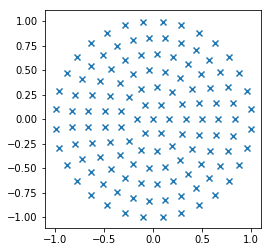

In [71]:
theta_0 = 0.
loss = bd.log_optimality(bd.a_optimality(get_cov_points))

#initial_design = construct_initial_greedy(loss, n_pts)
initial_design = construct_initial_ring(n_rings, 64)
print
plt.scatter(initial_design[:,0], initial_design[:,1], marker='x')
plt.gca().set_aspect('equal')
print loss(initial_design, np.array([greedy_ls, kernel_variance_mult]))

In [74]:
new_design = coordinate_exchange(initial_design, 20, loss, 50, False)
print loss(new_design, optimize_ls(new_design))

Iteration 0 Accepted 7/20 with length_scale 0.3
Iteration 1 Accepted 8/20 with length_scale 0.3
Iteration 2 Accepted 9/20 with length_scale 0.3
Iteration 3 Accepted 7/20 with length_scale 0.3
Iteration 4 Accepted 2/20 with length_scale 0.3
-529.423578776


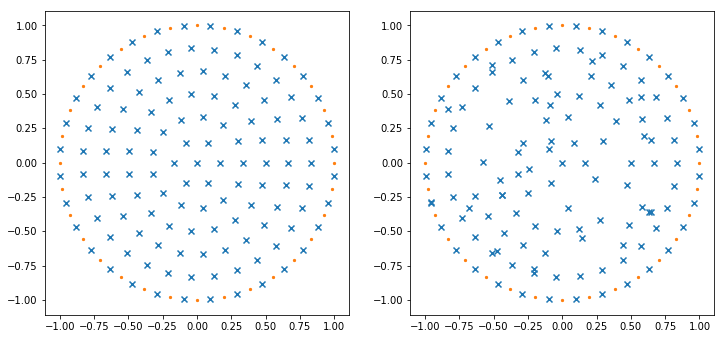

In [75]:

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(initial_design[:,0], initial_design[:,1], marker='x')
plt.scatter(sensors[:,0], sensors[:,1], marker='o', s=5)
plt.gca().set_aspect('equal')
plt.subplot(122)
plt.scatter(new_design[:,0], new_design[:,1], marker='x')
plt.scatter(sensors[:,0], sensors[:,1], marker='o', s=5)
plt.gca().set_aspect('equal')

In [46]:
np.save('eit_designs/optimized_n={}.npy'.format(len(new_design)), new_design)
np.save('eit_designs/initial_n={}.npy'.format(len(new_design)), initial_design)

In [47]:
print len(new_design)

127
